In [1]:
import pandas as pd
import yfinance as yf
from zipline.api import order_target_percent, record, symbol,order
import zipline
from zipline import run_algorithm
from zipline.utils.calendar_utils import get_calendar
from zipline.finance.commission import PerShare
from zipline.api import set_slippage, set_commission
import quantstats as qs

In [2]:
bundle = 'SP500'
calendar_name = 'NYSE'
calendar = get_calendar(calendar_name)

In [4]:
def initialize(context):
    context.asset = symbol('sp500')
    context.signal = pd.read_csv('../../data/sp500_test_forecast.csv', index_col=0, parse_dates=True)
    context.signal.index = pd.to_datetime(context.signal.index)
    context.prev_signal = None
    set_commission(PerShare(cost=0.003))
    context.short = 0
    context.long = 0
    #context.idx = 0
def handle_data(context,data):
    pricedic = {}
    today = pd.Timestamp(data.current_dt.date())
    
    
 
    signal_today = context.signal.loc[today]['Forecast']
    
    if signal_today != context.prev_signal:
        context.prev_signal = signal_today
        if signal_today == 1:
            if context.short!=2:
                order_target_percent(context.asset,0.5)
                context.long += 1
                pricedic[context.asset] = (data.current(context.asset, 'close'))
            else:
                order_target_percent(context.asset,0)
                context.short = 0
                   
        elif signal_today == -1:
            if context.long!=2:
                order_target_percent(context.asset,-0.5)
                context.short += 1
                pricedic[context.asset] = (data.current(context.asset, 'close'))
            else: 
                order_target_percent(context.asset,0)
                context.long = 0
            
    
    #context.idx +=1
    record(PRI=pricedic)

start = pd.Timestamp('2022-07-28')
end = pd.Timestamp('2023-07-22')
capital_base = 100000
results = run_algorithm(start = start,
                        end = end,
                        initialize = initialize,
                        handle_data = handle_data,
                        capital_base=capital_base,
                        trading_calendar= calendar,
                        bundle = bundle,
                        data_frequency= 'daily')

[*********************100%***********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2022-08-01   2022-08-01
End Period                 2023-07-21   2023-07-21
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       87.0%

Cumulative Return          9.83%        9.71%
Active Return              0.0%         -0.12%
CAGR﹪                     6.9%         6.82%

Sharpe                     0.6          0.92
Prob. Sharpe Ratio         72.5%        83.07%
Smart Sharpe               0.57         0.87
Sortino                    0.91         1.56
Smart Sortino              0.86         1.48
Sortino/√2                 0.65         1.11
Smart Sortino/√2           0.61         1.05
Omega                      1.22         1.22

Max Drawdown               -16.91%      -6.73%
Longest DD Days            297          163
Volatility (ann.)          18.9%        11.0%
R^2                        0.19         0.19
Information Ratio     

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2023-01-24,2023-03-13,2023-07-05,163,-6.730631,-6.302280
2,2022-11-23,2023-01-05,2023-01-20,59,-4.846181,-4.792552
3,2022-10-31,2022-11-03,2022-11-09,10,-4.621811,-3.890158
4,2022-10-07,2022-10-20,2022-10-24,18,-4.169243,-3.666748
5,2022-08-19,2022-08-26,2022-09-08,21,-1.689131,-1.667173


Slippage: -427.06754500000125
Slippage Lost: -9.778764999997748
Total Commission: 6.804


Average Long Exposure = 30569.46085020243
Average Short Exposure = -17462.69028340081
Average Net Leverage = 0.1253039545285201
Average Gross Leverage = 0.455379153503021
Max Leverage = 5.91829814371237



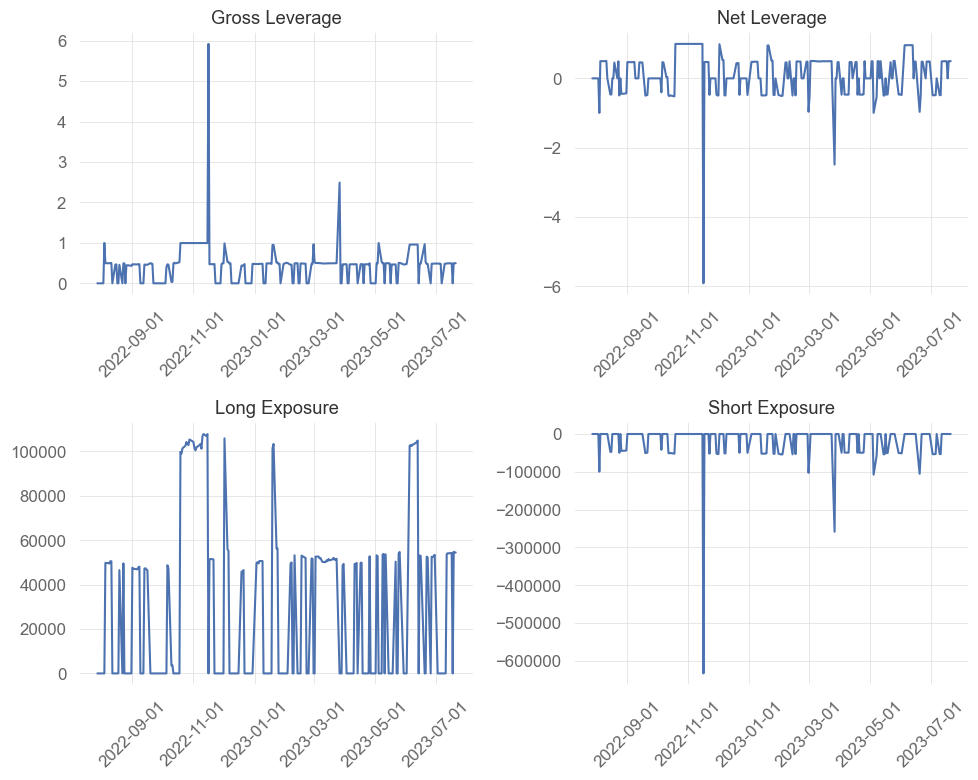

SP500





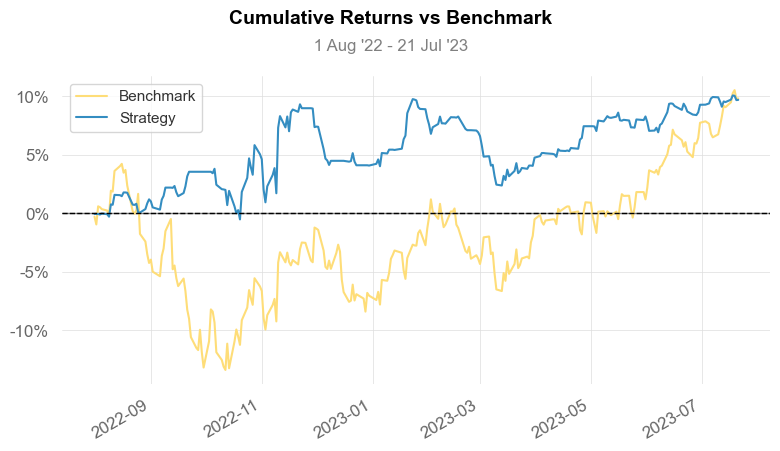

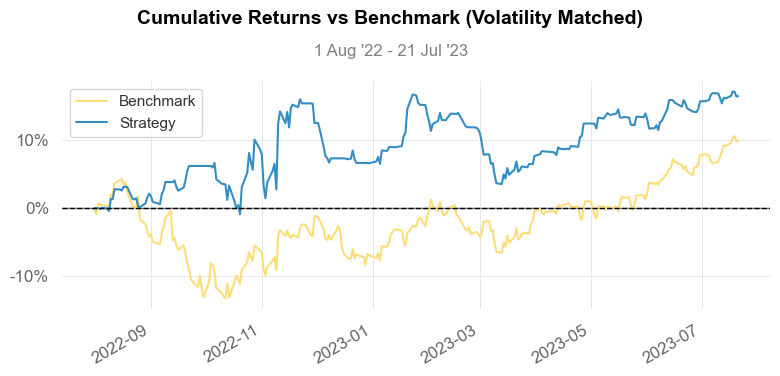

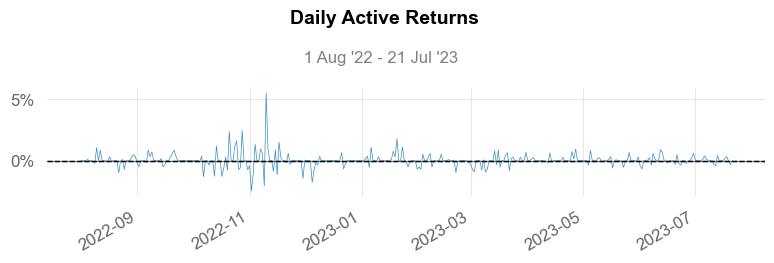

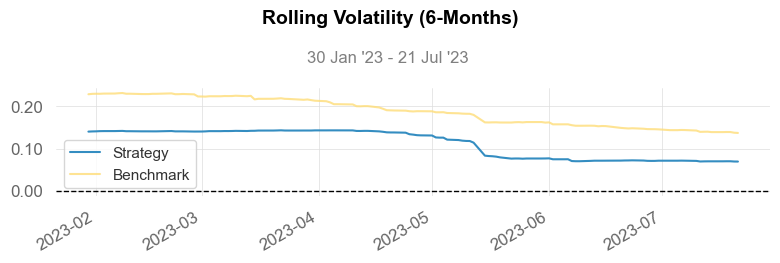

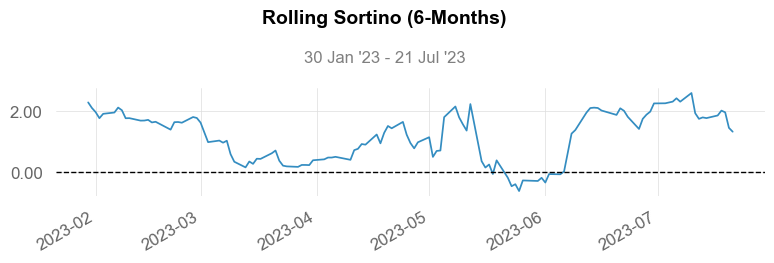

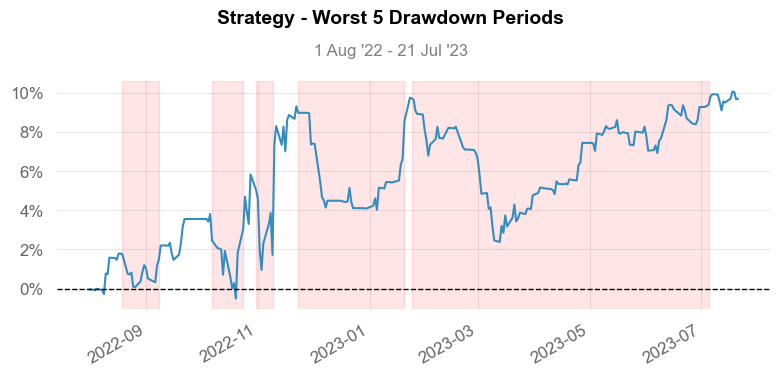

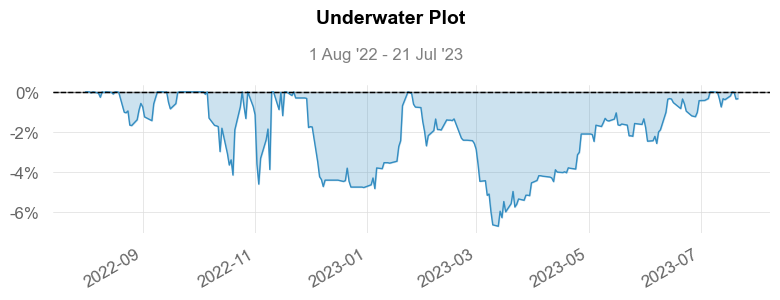

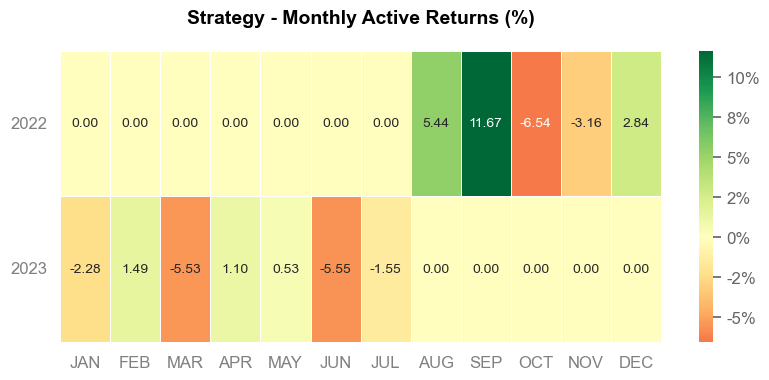

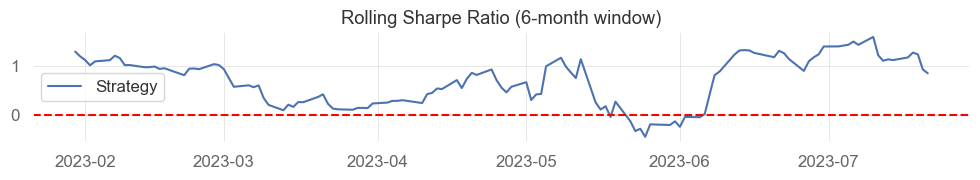

[*********************100%***********************]  1 of 1 completed


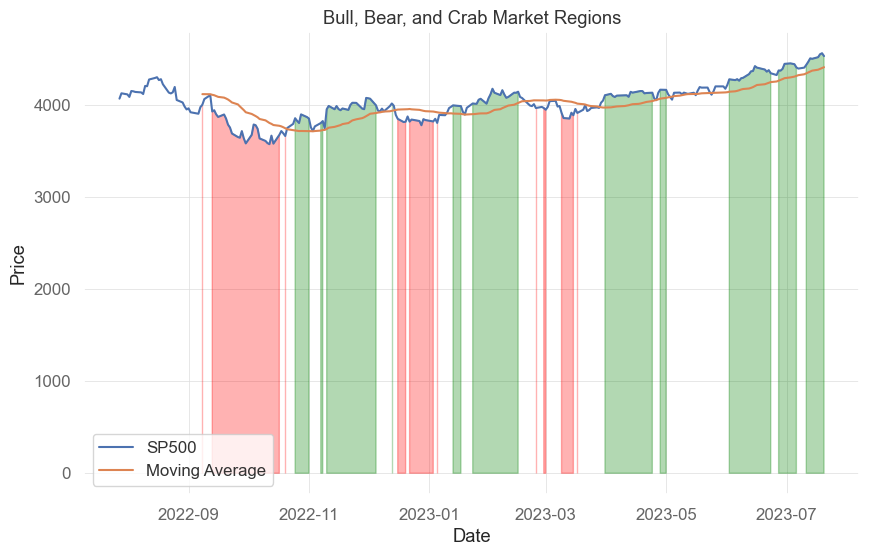

Total Trades: 121
Daily Trades: 1
Weekly Trades: 5
Monthly Trades: 21





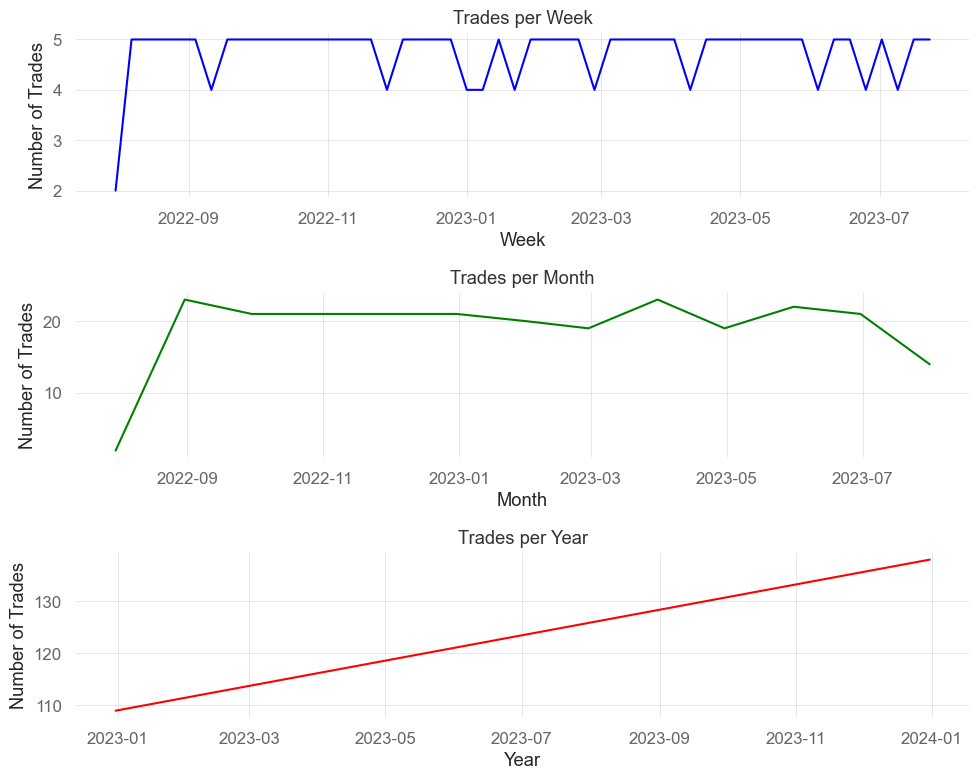

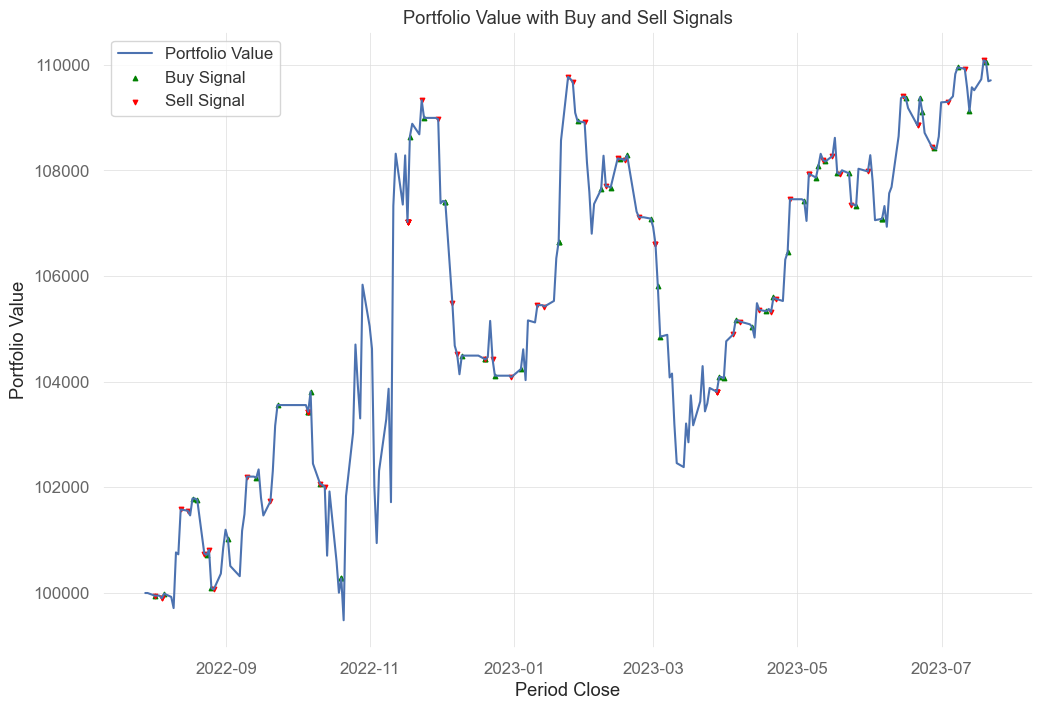

In [4]:
start_date = results.index[0]
end_date = results.index[-1]
benchmark = yf.download('^GSPC', start=start_date, end=end_date)['Adj Close'].pct_change()
results.index = pd.to_datetime(results.index)
results.index = benchmark.index    
qs.reports.full(results['returns'], benchmark = benchmark, match_dates=True, figsize=(8, 4), df = results)

### More aggressive one 

In [24]:
def initialize(context):
    context.asset = symbol('sp500')
    context.signal = pd.read_csv('../../data/sp500_test_forecast.csv', index_col=0, parse_dates=True)
    context.signal.index = pd.to_datetime(context.signal.index)
    context.previous_signal = None
    set_commission(PerShare(cost=0.003))
    context.short_position = False
    context.long_position = False
    #context.idx = 0
def handle_data(context,data):
    pricedic = {}
    today = pd.Timestamp(data.current_dt.date())
    
    
 
    prediction = context.signal.loc[today]['Forecast']
    
    
    if prediction == context.previous_signal:
        return

    # Check the current portfolio position and switch if necessary
    if context.long_position and prediction == -1:  # Close long position and go short
        order_target_percent(context.asset, -1)
        context.long_position = False
        context.short_position = True
        pricedic[context.asset] = (data.current(context.asset, 'close'))
    elif context.short_position and prediction == 1:  # Close short position and go long
        order_target_percent(context.asset, 1)
        context.long_position = True
        context.short_position = False
        pricedic[context.asset] = (data.current(context.asset, 'close'))

    # Open new position if needed
    if not context.long_position and not context.short_position:
        if prediction == 1:  # Go long
            order_target_percent(context.asset, 1)
            context.long_position = True
            pricedic[context.asset] = (data.current(context.asset, 'close'))
        elif prediction == -1:  # Go short
            order_target_percent(context.asset, -1)
            context.short_position = True
            pricedic[context.asset] = (data.current(context.asset, 'close'))
    context.previous_signal = prediction        
    
    #context.idx +=1
    record(PRI=pricedic)

start = pd.Timestamp('2022-07-28')
end = pd.Timestamp('2023-07-22')
capital_base = 100000
results = run_algorithm(start = start,
                        end = end,
                        initialize = initialize,
                        handle_data = handle_data,
                        capital_base=capital_base,
                        trading_calendar= calendar,
                        bundle = bundle,
                        data_frequency= 'daily')

[*********************100%***********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2022-08-01   2022-08-01
End Period                 2023-07-21   2023-07-21
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          9.83%        20.65%
Active Return              0.0%         10.82%
CAGR﹪                     6.9%         14.3%

Sharpe                     0.6          0.76
Prob. Sharpe Ratio         72.5%        78.75%
Smart Sharpe               0.54         0.68
Sortino                    0.91         1.39
Smart Sortino              0.81         1.24
Sortino/√2                 0.65         0.98
Smart Sortino/√2           0.58         0.88
Omega                      1.17         1.17

Max Drawdown               -16.91%      -21.16%
Longest DD Days            297          241
Volatility (ann.)          18.9%        31.72%
R^2                        0.18         0.18
Information Ratio 

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-11-23,2023-03-13,2023-07-21,241,-21.162698,-20.414465
2,2022-10-31,2022-11-03,2022-11-09,10,-12.993285,-10.936391
3,2022-10-07,2022-10-20,2022-10-21,15,-8.140023,-6.278495
4,2022-08-19,2022-08-26,2022-09-20,33,-7.967260,-7.398151
5,2022-09-23,2022-09-30,2022-10-03,11,-4.424613,-3.016653


Slippage: -518.6124050000049
Slippage Lost: 213.1875950000035
Total Commission: 20.400000000000002


Average Long Exposure = 92384.1116194332
Average Short Exposure = -58453.27643724696
Average Net Leverage = 0.29590628179325407
Average Gross Leverage = 1.3059572764779972
Max Leverage = 17.45168914474627



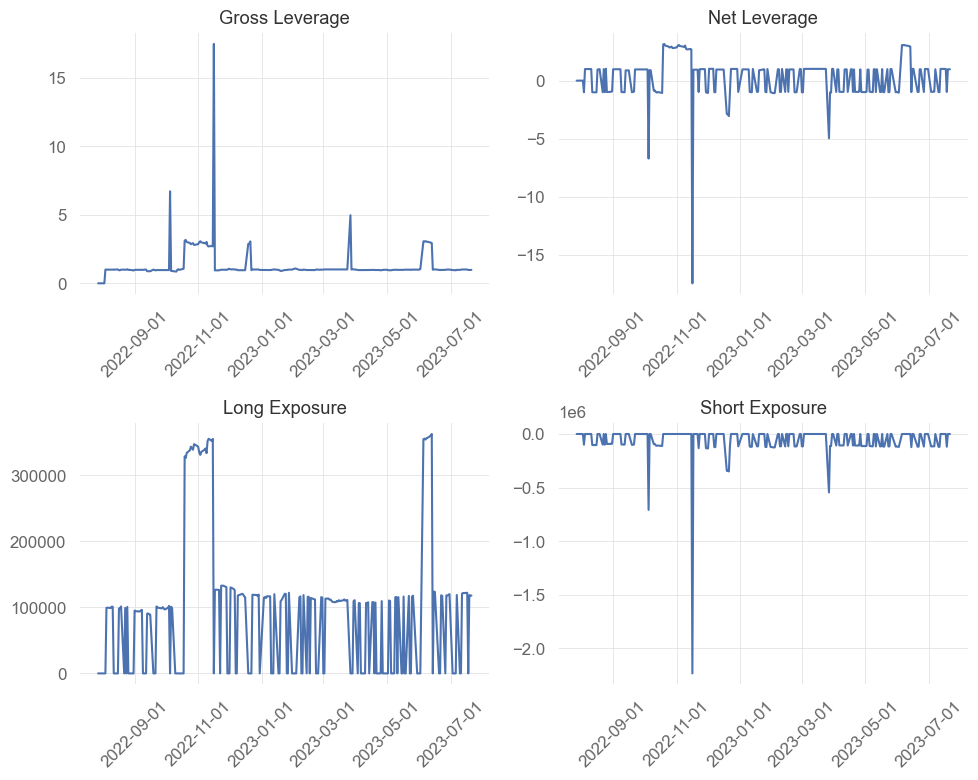

SP500





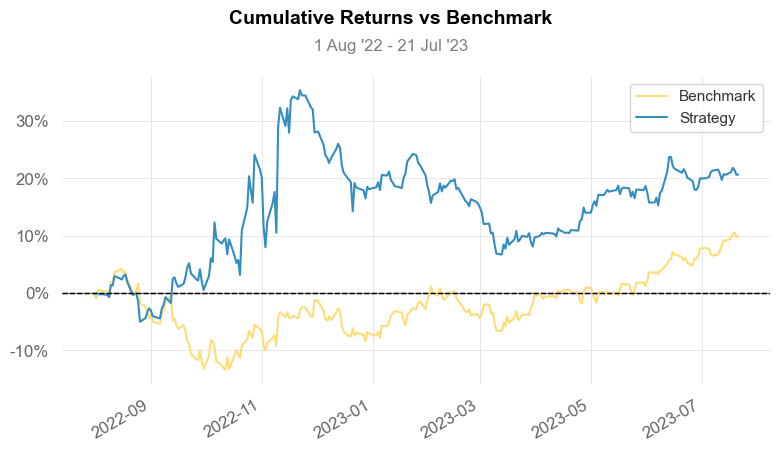

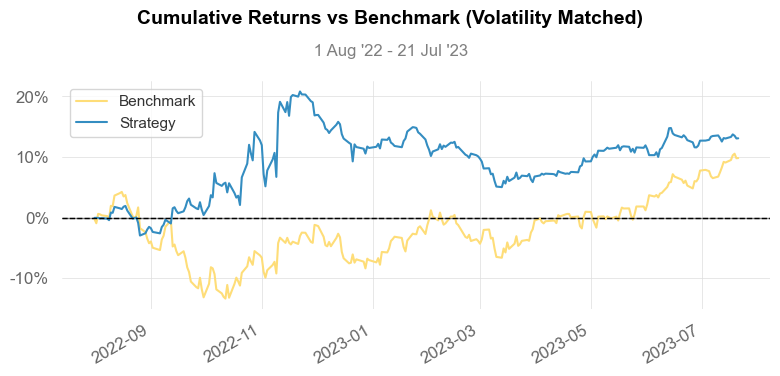

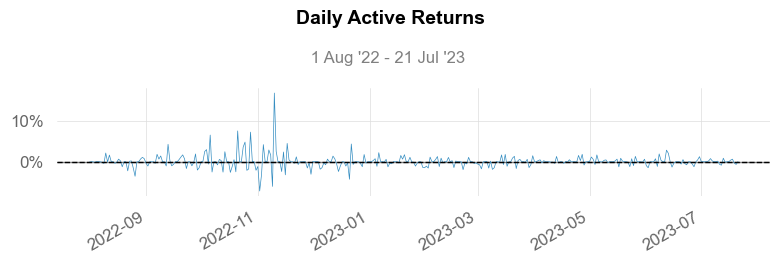

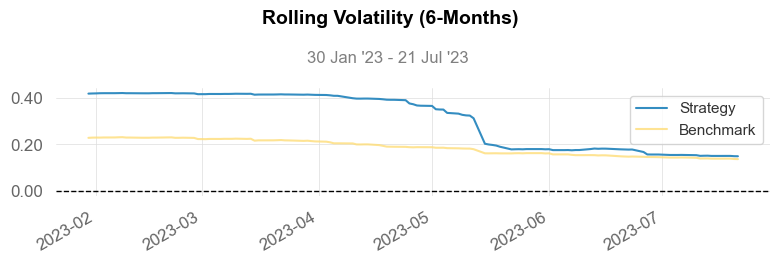

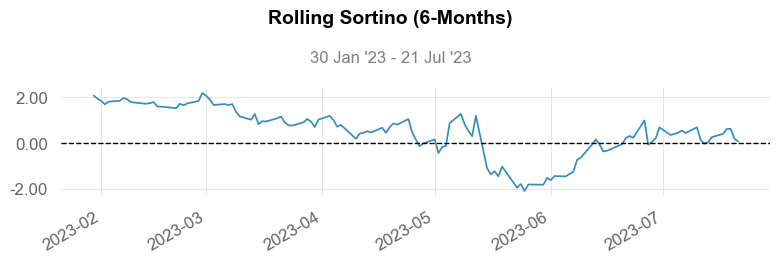

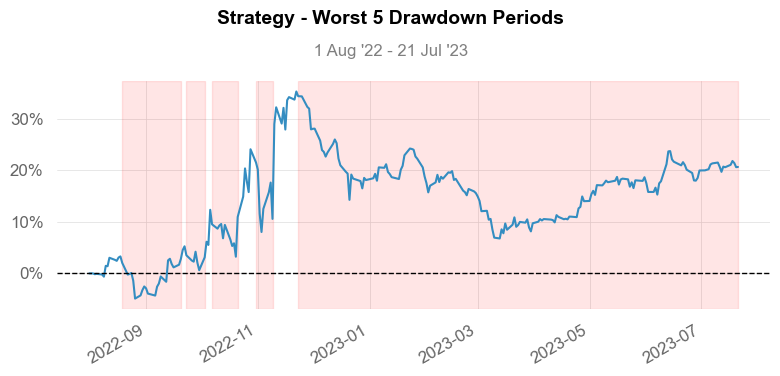

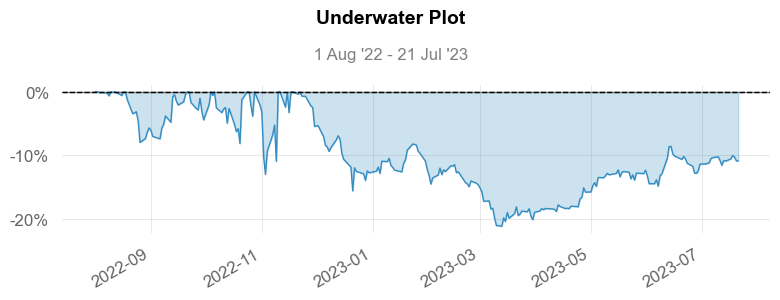

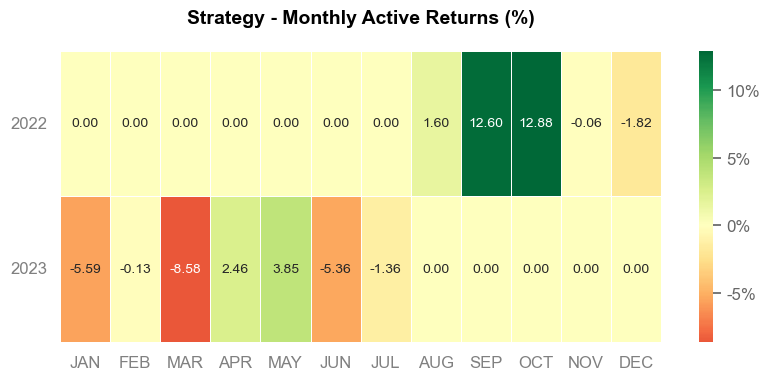

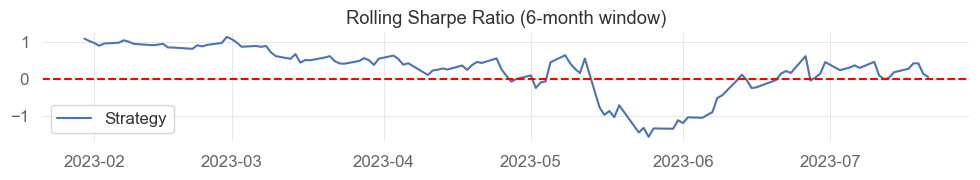

[*********************100%***********************]  1 of 1 completed


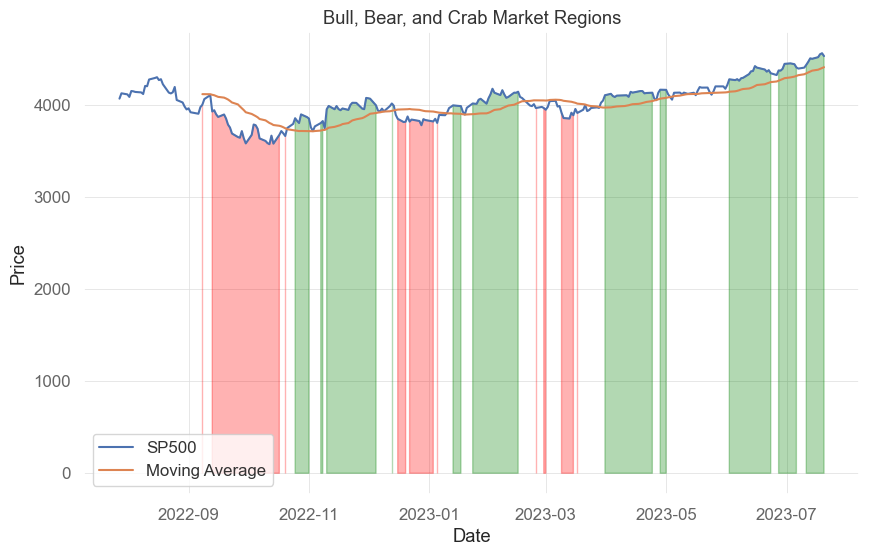

Total Trades: 120
Daily Trades: 1
Weekly Trades: 5
Monthly Trades: 21





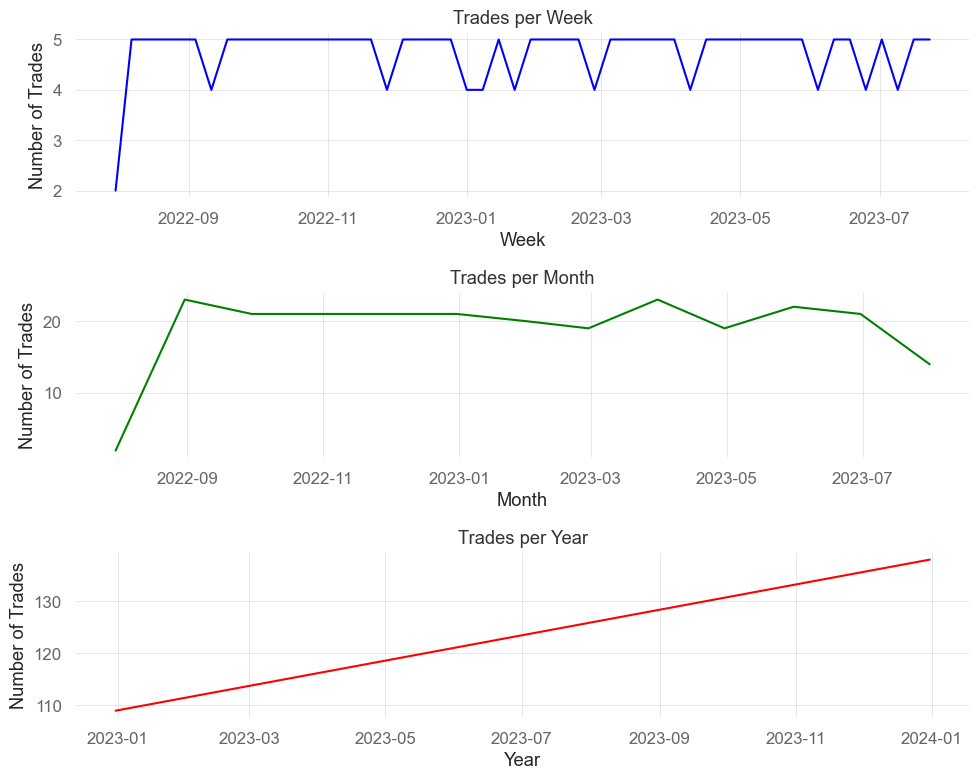

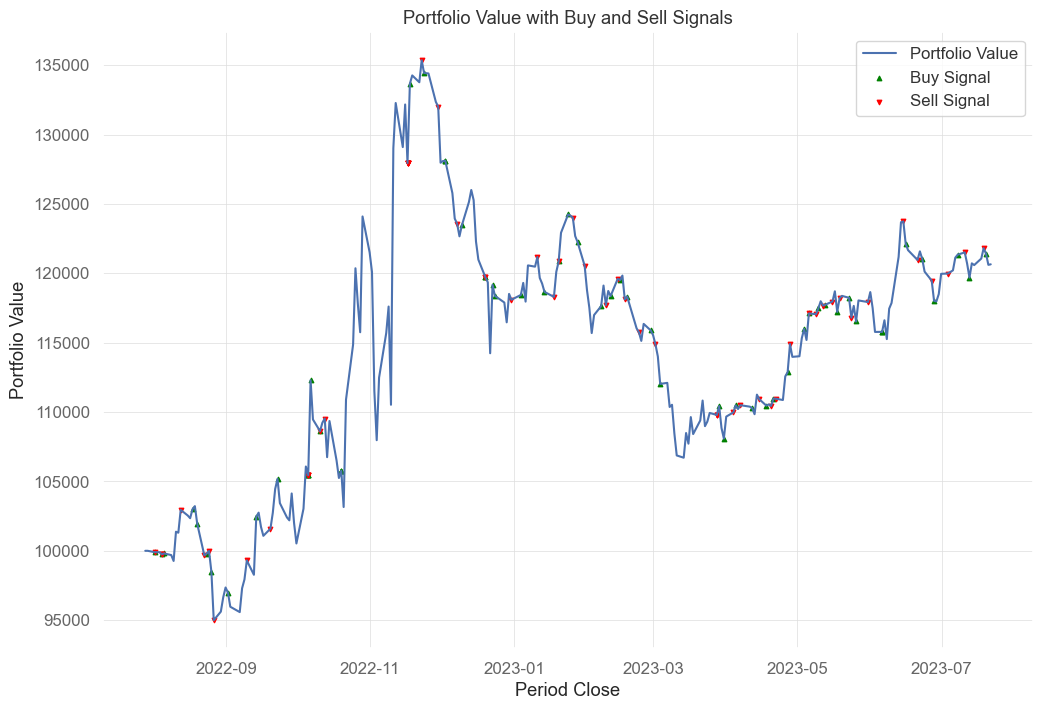

In [25]:
start_date = results.index[0]
end_date = results.index[-1]
benchmark = yf.download('^GSPC', start=start_date, end=end_date)['Adj Close'].pct_change()
results.index = pd.to_datetime(results.index)
results.index = benchmark.index    
qs.reports.full(results['returns'], benchmark = benchmark, match_dates=True, figsize=(8, 4), df = results)